# Configs

In [1]:
import os
import torch
import numpy as np
import mdtraj as md
import nglview as nv

import openmm as mm
import openmm.unit as unit
from openmm import app

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

PHI_ANGLE = [4, 6, 8, 14]
PSI_ANGLE = [6, 8, 14, 16]
ALANINE_HEAVY_ATOM_IDX = [1, 4, 5, 6, 8, 10, 14, 15, 16, 18]

n_particles = 22
n_dimensions = 3
scaling = 10
dim = n_particles * n_dimensions

def compute_dihedral(positions):
    """http://stackoverflow.com/q/20305272/1128289"""
    def dihedral(p):
        if not isinstance(p, np.ndarray):
            p = p.numpy()
        b = p[:-1] - p[1:]
        b[0] *= -1
        v = np.array([v - (v.dot(b[1]) / b[1].dot(b[1])) * b[1] for v in [b[0], b[2]]])
        
        # Normalize vectors
        v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1, 1)
        b1 = b[1] / np.linalg.norm(b[1])
        x = np.dot(v[0], v[1])
        m = np.cross(v[0], b1)
        y = np.dot(m, v[1])
        
        return np.arctan2(y, x)
    
    return np.array(list(map(dihedral, positions)))


# Datset

### Original TBG

In [11]:
#TBG dataset
pdb_file = "../data/AD2/c5-modified.pdb"
data_path = "../data/AD2/AD2_weighted.npy"
data = np.load(data_path)
data = data.reshape(data.shape[0], 22, 3)
data = data 
print(data.shape)

(100000, 22, 3)


In [61]:
from bgmol.datasets import AImplicitUnconstrained
from bgflow import MeanFreeNormalDistribution

dataset = AImplicitUnconstrained(root=os.getcwd()+"/../",read=True, download=False)
target = dataset.get_energy_model()

Using downloaded and verified file: /tmp/A.pdb


/home/shpark/prj-mlcv/lib/bgflow/bgflow/distribution/energy/openmm.py:200: UserWarning: It looks like you are using an OpenMMBridge with multiple workers in an ipython environment. This can behave a bit silly upon KeyboardInterrupt (e.g., kill the stdout stream). If you experience any issues, consider initializing the bridge with n_workers=1 in ipython/jupyter.
  warnings.warn(


In [62]:
classical_model_energies = target.energy(torch.from_numpy(data.reshape(-1, 66)).cuda()).cpu().detach().numpy()
prior = MeanFreeNormalDistribution(dim, n_particles, two_event_dims=False).cuda()
log_w_np = -classical_model_energies + prior.energy(torch.from_numpy(latent_np).cuda()).cpu().detach().numpy() + dlogp_np.reshape(-1,1)

In [99]:
phi = compute_dihedral(data[:, PHI_ANGLE])
psi = compute_dihedral(data[:, PSI_ANGLE])
print(phi.shape, psi.shape)

(100000,) (100000,)


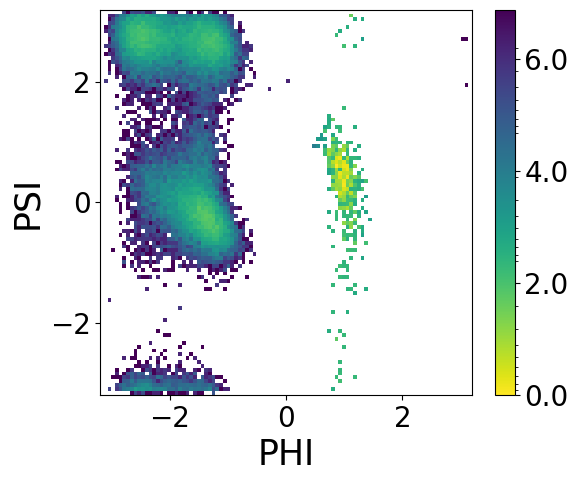

In [100]:
fig, ax = plt.subplots(figsize=(6, 5))
plot_range = [-3.2, 3.2]
h, x_bins, y_bins, im = ax.hist2d(phi, psi, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_xlabel("PHI", fontsize=25)
ax.set_ylabel("PSI", fontsize=25)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
cbar = fig.colorbar(im, ticks=ticks)
cbar.ax.set_yticklabels([6.0,4.0,2.0,0.0], fontsize=20)
cbar.ax.invert_yaxis()

### Our dataset

In [ ]:
# Our datset
custom_data = torch.load("../../../simulation/dataset/alanine/300.0/tbg-10n/current-xyz.pt")
custom_data = custom_data.reshape(-1, n_particles, n_dimensions)

ad2_topology = md.load("../data/AD2/c5.pdb").topology
traj_samples = md.Trajectory(custom_data, topology=ad2_topology)

phis = md.compute_phi(traj_samples)[1].flatten()
psis = md.compute_psi(traj_samples)[1].flatten()
print(phis.shape, psis.shape)

(10000,) (10000,)


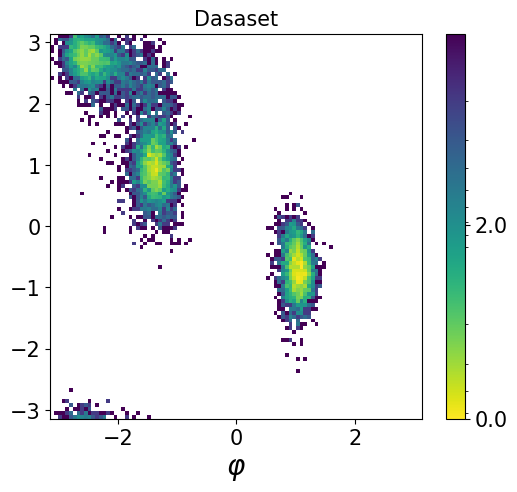

In [15]:

fig, ax = plt.subplots(figsize=(6, 5))
plot_range = [-np.pi, np.pi]

h, x_bins, y_bins, im = ax.hist2d(phis, psis, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_xlabel(r"$\varphi$", fontsize=20)
ax.set_title("Dasaset", fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

cbar = fig.colorbar(im, ticks=ticks)
cbar.ax.set_yticklabels([6.0,4.0,2.0,0.0], fontsize=15)
cbar.ax.invert_yaxis()
# cbar.ax.set_ylabel(r"Free energy / $k_B T$", fontsize=15)



In [4]:
custom_data = torch.load("../../../simulation/dataset/alanine/300.0/10n-v1/distance.pt")
custom_data.shape


torch.Size([10000, 45])

In [5]:
custom_data[0]

tensor([0.1525, 0.2393, 0.2395, 0.3817, 0.4802, 0.4726, 0.4782, 0.5679, 0.6868,
        0.1202, 0.1326, 0.2468, 0.3547, 0.3524, 0.3902, 0.4370, 0.5675, 0.2230,
        0.2790, 0.3876, 0.3791, 0.4431, 0.4310, 0.5622, 0.1508, 0.2495, 0.2641,
        0.2960, 0.3714, 0.5035, 0.1511, 0.1561, 0.2412, 0.2464, 0.3884, 0.2571,
        0.3363, 0.3289, 0.4630, 0.1245, 0.1294, 0.2466, 0.2224, 0.2824, 0.1484])

## 2AA dataset

# Energy

In [8]:
def init_simulation():
    pdb = app.PDBFile(pdb_file)
    forcefield = app.ForceField("amber99sbildn.xml", "tip3p.xml")
    system = forcefield.createSystem(
		pdb.topology,
		nonbondedMethod=app.PME,
		constraints=app.HBonds,
		ewaldErrorTolerance=0.0005,
	)
    integrator = mm.LangevinIntegrator(
        300.0 * unit.kelvin,
        0.001 / unit.femtoseconds,
        1 * unit.femtoseconds
    )
    platform = mm.Platform.getPlatformByName("OpenCL")
    properties = {'DeviceIndex': '0', 'Precision': "mixed"}

    simulation = app.Simulation(
        pdb.topology,
        system,
        integrator,
        platform,
        properties
    )        
    simulation.context.setPositions(pdb.positions)   
    simulation.minimizeEnergy()
    
    return simulation

def set_simulation(simulation, frame):
    if frame is not None:
        atom_xyz = frame
        atom_list = [mm.Vec3(atom[0], atom[1], atom[2]) for atom in atom_xyz]
        current_state_openmm = unit.Quantity(value=atom_list, unit=unit.nanometer)
        simulation.context.setPositions(current_state_openmm)
    else:
        raise ValueError("Frame is None")
    
    simulation.context.setVelocities(unit.Quantity(value=np.zeros(frame.shape), unit=unit.nanometer/unit.picosecond))
    
    return simulation

def potential_energy(trajectory):
	simulation = init_simulation()
	energy_list = []

	for frame in tqdm(
		trajectory,
		desc="Calculating potential energy",
	):
		simulation = set_simulation(simulation, frame)
		energy = simulation.context.getState(getEnergy=True).getPotentialEnergy()
		energy_list.append(energy._value)

	return np.array(energy_list)

In [12]:
data_energy = potential_energy(data)
print(data_energy.shape)

Calculating potential energy:   0%|          | 0/25600 [00:00<?, ?it/s]

(25600,)


In [13]:
print(data_energy.max())
print(data_energy.min())

204124408542.88962
-62.35165385977865


In [14]:
molecule = "alanine"
temperature = "300.0"
version = "timelag-1n-lag30"
dataset_dir = f"../../../simulation/dataset/{molecule}/{temperature}/{version}/"
data = torch.load(f"{dataset_dir}xyz-aligned-timelag.pt")
data.shape

torch.Size([10000, 22, 3])

In [15]:
dataset_energy = potential_energy(data)
print(dataset_energy.shape)

Calculating potential energy:   0%|          | 0/10000 [00:00<?, ?it/s]

(10000,)


Text(0.5, 1.0, 'Energy distribution')

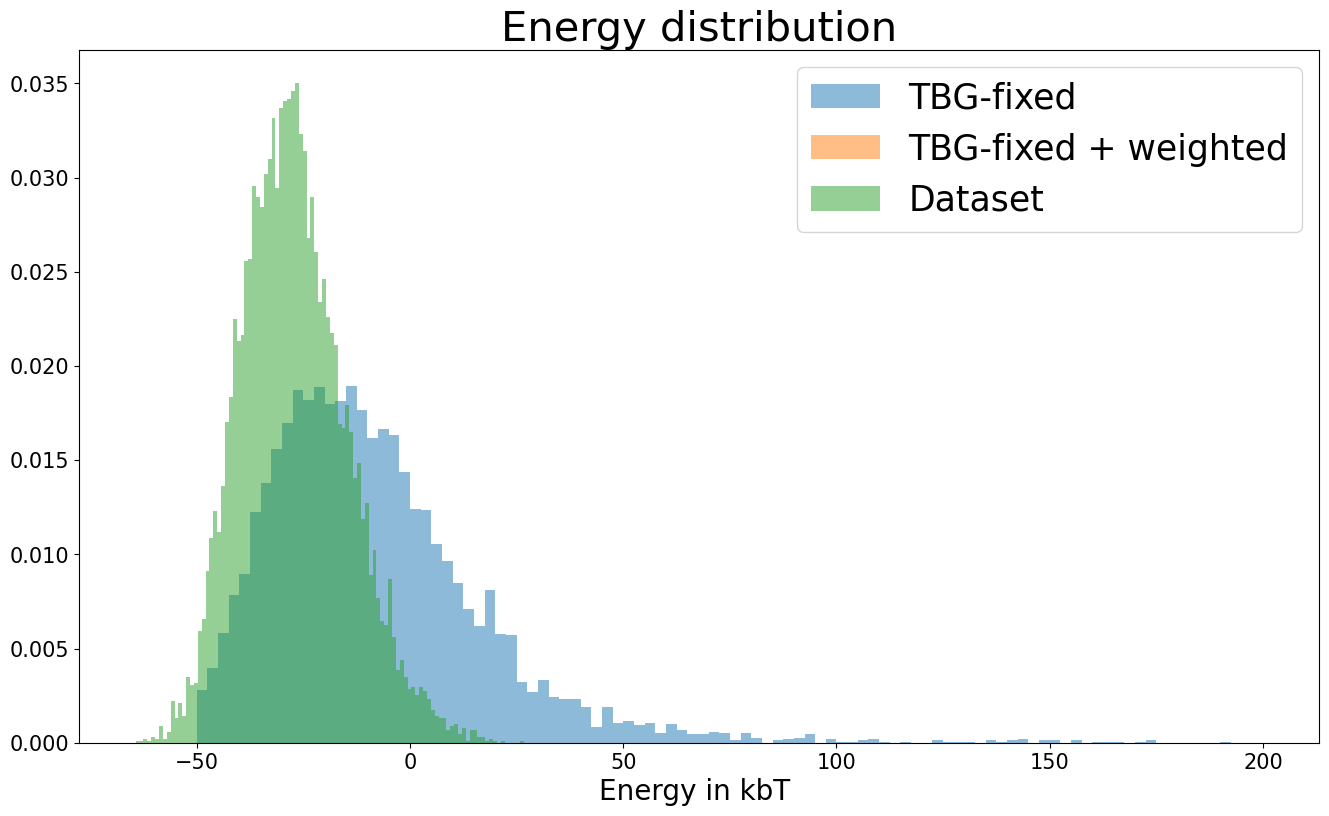

In [65]:
plt.figure(figsize=(16,9))

# plt.hist(np.log10(data_energy), bins=100, alpha=0.5, density=True);
plt.hist(data_energy, bins=100, range=(-50, 200), alpha=0.5, density=True, label="TBG-fixed")
plt.hist(data_energy, bins=100, range=(-50, 200), alpha=0.5, density=True, label="TBG-fixed + weighted", weights=np.exp(log_w_np))
plt.hist(dataset_energy, bins=100, alpha=0.5, density=True, label=f"Dataset");

plt.legend(fontsize=25)
plt.xlabel("Energy in kbT ", fontsize=20)  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Energy distribution", fontsize=30)